In [1]:
############# NOTEBOOK PARAMETERS ##############

parameters = dict()
parameters['file'] = None # set to None for file prompt
parameters['cmap'] = 'viridis'
parameters['length_x'] = 40e-6
parameters['length_y'] = 40e-6
parameters['node_area'] = 5e-6 * 5e-6
parameters['density'] = 1000
parameters['sound_speed'] = 1500
parameters['angles'] = 0, 90, 1
################################################

import os
if not 'module_dir' in globals():
    module_dir = os.path.join(os.getcwd(), '..')
os.chdir(module_dir)

from notebook_functions import *
from scipy.spatial.distance import cdist as distance

In [12]:
## FUNCTIONS ##

def load_data(file):
    
    with closing(sql.connect(file)) as con:
        
        q = 'SELECT frequency, displacement_real, displacement_imag FROM displacements ORDER BY frequency, x, y, z'
        displacements_table = pd.read_sql(q, con)
        
        q = 'SELECT x, y, z, membrane_id, element_id, channel_id FROM nodes ORDER BY x, y, z'
        nodes_table = pd.read_sql(q, con)
    
    freqs = np.unique(np.array(displacements_table['frequency']))
    nfreqs = len(freqs)
    displacements = np.array(displacements_table['displacement_real'] + 1j * displacements_table['displacement_imag'])
    displacements = displacements.reshape((-1, nfreqs), order='F')
    nodes = np.array(nodes_table[['x', 'y', 'z']])
    membrane_ids = np.array(nodes_table['membrane_id'])
    element_ids = np.array(nodes_table['element_id'])
    channel_ids = np.array(nodes_table['channel_id'])
    
    return displacements, freqs, nodes, membrane_ids, element_ids, channel_ids


def calculate_directivity(x, nodes, freqs, angles, node_area, rho, c):
    
    angle_start, angle_stop, angle_step = angles
    r = 0.05
    py = np.arange(angle_start, angle_stop + angle_step, angle_step)
    px = 0
    fieldpos = meshview(r, py, px, mode='sector')
    npos = len(fieldpos)
    
    dr = np.zeros((npos, nfreqs), dtype=np.complex128)

    for i, pos in tqdm(enumerate(fieldpos), total=npos):
        
        d = distance(*np.atleast_2d(pos, nodes))
        p = np.zeros(nfreqs, dtype=np.complex128)
        
        for j, f in enumerate(freqs):

            k = 2 * np.pi * f / c
            q = node_area * 1j * 2 * np.pi * f * x[:,j] * 2 # 2x for baffled condition

            p[j] = np.sum(1j * k * rho * c / (4 * np.pi) * np.exp(-1j * k * d) / d * q, -1).squeeze()

        dr[i, :] = p
    
    return dr
    
    
## LOAD DATA ##

if parameters['file'] is None:
    parameters['file'] = open_file_dialog()

x, freqs, nodes, membrane_ids, element_ids, channel_ids = load_data(parameters['file'])

nmem = len(np.unique(membrane_ids))
nfreqs = len(freqs)

x_mem = list()
nodes_mem = list()
for i in range(nmem):
    x_mem.append(x[membrane_ids == i, :])
    nodes_mem.append(nodes[membrane_ids == i, :])
x_mem = np.array(x_mem)
nodes_mem = np.array(nodes_mem)

x_mem_std = np.var(np.abs(x_mem), axis=1)
x_mean_std = np.var(np.mean(np.abs(x_mem), axis=1), axis=0)

node_area = parameters['node_area']
rho = parameters['density']
c = parameters['sound_speed']
angles = parameters['angles']

dr = calculate_directivity(x, nodes, freqs, angles=angles, node_area=node_area, rho=rho, c=c)


HBox(children=(IntProgress(value=0, max=91), HTML(value='')))

### <center>Notebook parameters</center>

In [ ]:
display(HTML('<center>' + tabulate.tabulate(parameters.items(), tablefmt='html') + '</center>'))

### <center>Plots</center>

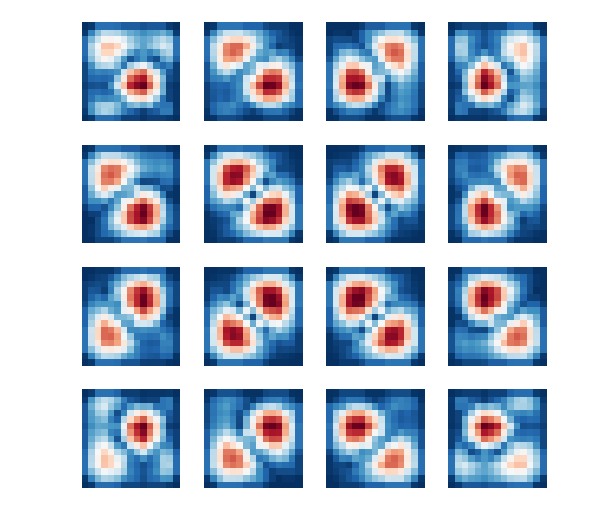

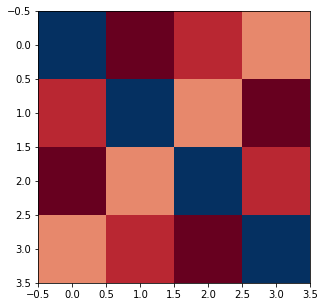

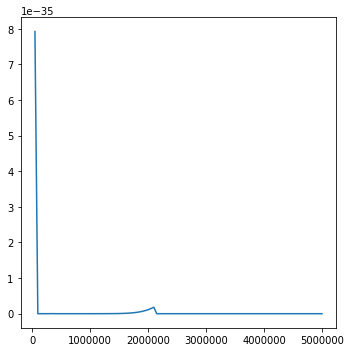

In [51]:
def interpolate_surfaces(x_mem, nodes_mem, freqs, f, length_x, length_y, grid=(16, 16)):

    i = np.argmin(np.abs(f - freqs))
    ngridx, ngridy = grid
    nmem = x_mem.shape[1]
    surfs = list()

    for mem, nodes in zip(x_mem, nodes_mem):

        x, y, z = nodes.T
        d = np.abs(mem[:, i])

        xc = (x.min() + x.max()) / 2
        yc = (y.min() + y.max()) / 2

        nptx = len(np.unique(x))
        npty = len(np.unique(y))
        
        xv = np.linspace(xc - length_x / 2, xc + length_y / 2, nptx + 2)
        yv = np.linspace(yc - length_x / 2, yc + length_y / 2, npty + 2)
        x, y = map(np.ravel, np.meshgrid(xv, yv))
        d = np.pad(d.reshape((nptx, npty)), ((1, 1), (1, 1)), mode='constant').ravel()
        
        xg = np.linspace(xc - length_x / 2, xc + length_x / 2, ngridx)
        yg = np.linspace(yc - length_y / 2, yc + length_y / 2, ngridy)
        
        xi = xg[:-1] + np.diff(xg) / 2
        yi = yg[:-1] + np.diff(yg) / 2
        di = griddata((x, y), d, (xi[:, None], yi[None, :]), method='linear', fill_value=0)

        xx, yy = np.meshgrid(xg, yg)

        surfs.append((xx, yy, di))

    return surfs


def surface_plot(x_mem, nodes_mem, freqs, f, cmap='RdBu_r', length_x=40e-6, length_y=40e-6, ax=None, update=False):
    
    surfs = interpolate_surfaces(x_mem, nodes_mem, freqs, f, length_x, length_y)
    
    if not update:
        
        for xx, yy, di in surfs:
            im = ax.pcolormesh(xx, yy, di, cmap=cmap, shading='flat')

        ax.set_axis_off()
        ax.set_aspect('equal')
        ax.set_xlim(-1e-4, 1e-4)
        ax.set_ylim(-1e-4, 1e-4)
        
    else:
        
        for im in [a for a in ax.get_children() if isinstance(a, matplotlib.collections.QuadMesh)]:
            im.remove()
            
        for xx, yy, di in surfs:
            im = ax.pcolormesh(xx, yy, di, cmap=cmap, shading='flat')
            

def mean_displacement_plot(x_mem, freqs, f, nmem_x, nmem_y, cmap='RdBu_r', ax=None, update=False):
    
    i = np.argmin(np.abs(f - freqs))
    
    x_mean = np.mean(np.abs(np.array(x_mem)[..., i]), axis=1).reshape((nmem_x, nmem_y))
    
    if not update:
        
        ax.imshow(x_mean, cmap=cmap)
        
    else:
        pass


def membrane_variance_plot(x_mean_var, freqs, ax=None, update=False):
    
    if not update:
        
        ax.plot(freqs, x_mean_var)
    
    else:
        pass


def directivity_plot(dr, angles, freqs, f, ax=None, lines=None, update=False):
    
    i = np.argmin(np.abs(f - freqs))

    d = 20 * np.log10(np.abs(dr[:, i]) / np.max(np.abs(dr[:, i])))
    d[d < -60] = -60
    theta = np.deg2rad(angles)
    
    if not update:
        
        line, = ax.plot(theta, d)
        
        ax.set_rlim(-40, 0)
        ax.set_rticks([-40, -30, -20, -10, 0])
        ax.set_theta_zero_location('N')
    
        return [line,]

    else:
        
        lines[0].set_data(theta, d)



# def surface_variance_plot(v, freqs, f, ax=None, lines=None, update=False):

#     i = np.argmin(np.abs(f - freqs))
    
#     if not update:

#         v_line, = ax.plot(freqs/1e6, v, color=blue)
#         v_marker, = ax.plot(freqs[i]/1e6, v[i], color=blue, marker='o')

#         f_line = ax.axvline(x=freqs[i]/1e6, ls=':')

#         lines = [v_line, v_marker, f_line]
        
#         ax.set_xlim(0, freqs.max()/1e6)
#         ax.set_xlabel('Frequency (MHz)')
#         ax.set_ylabel('Displacement variance')
        
#         ax.grid('on')
        
#         return lines
    
#     else:

#         v_line, v_marker, f_line = lines
        
#         v_marker.set_data(freqs[i]/1e6, v[i])
#         f_line.set_xdata(freqs[i]/1e6)

f = 50e3

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
surface_plot(x_mem, nodes_mem, freqs, f, cmap='RdBu_r', ax=ax)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
mean_displacement_plot(x_mem, freqs, f, 4, 4, cmap='RdBu_r', ax=ax)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
membrane_variance_plot(x_mean_std, freqs, ax=ax)




plt.tight_layout()
plt.show()


# gs = GridSpec(2,1)
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# cid = fig.canvas.mpl_connect('button_press_event', onclick)
# surface_plot(header, f=10e6, ax=ax2, cmap='RdBu_r', update=False)

